In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import import_ipynb
from helpers import train_and_validate, count_parameters, plot_loss_comparison, plot_test_predictions, compare_mse_loss
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

importing Jupyter notebook from helpers.ipynb


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
window_size = 24
batch_size = 100
input_size = 1
hidden_size = 100
num_classes = 1
learning_rate = 0.001
epochs = 100
criterion = nn.MSELoss()

In [4]:
def root_mean_squared_error(actual, predicted):
    actual = torch.tensor(actual, dtype=torch.float32)
    predicted = torch.tensor(predicted, dtype=torch.float32)
    
    if actual.shape != predicted.shape:
        raise ValueError("Tensors must have the same shape.")
    
    mse = torch.mean((actual - predicted)**2)
    
    return (mse.item() ** 0.5)

In [5]:
df = pd.read_csv("../data/clean_woodland_data.csv")
df

,Date,P (kW)
0,2022-01-01 06:00:00,0.000000
1,2022-01-01 07:00:00,0.410583
2,2022-01-01 08:00:00,2.762083
3,2022-01-01 09:00:00,5.461250
4,2022-01-01 10:00:00,8.356167
...,...,...
25642,2024-12-04 16:00:00,6.669250
25643,2024-12-04 17:00:00,2.849417
25644,2024-12-04 18:00:00,0.398083
25645,2024-12-04 19:00:00,0.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25647 entries, 0 to 25646
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    25647 non-null  object 
 1   P (kW)  25647 non-null  float64
dtypes: float64(1), object(1)
memory usage: 400.9+ KB


In [7]:
df = df[["Date", "P (kW)"]]
train_df = df.iloc[:-24]
test = df.iloc[-24:]

In [8]:
def prepare_dataframe(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'P (kW)(t-{i})'] = df['P (kW)'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [9]:
new_df = prepare_dataframe(train_df, window_size)
new_df = new_df.to_numpy()
new_df

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.7620833e+00,
        4.1058330e-01, 0.0000000e+00],
       [7.4316670e-01, 0.0000000e+00, 0.0000000e+00, ..., 5.4612500e+00,
        2.7620833e+00, 4.1058330e-01],
       [4.3818335e+00, 7.4316670e-01, 0.0000000e+00, ..., 8.3561670e+00,
        5.4612500e+00, 2.7620833e+00],
       ...,
       [3.0066670e-01, 3.0534167e+00, 7.5616665e+00, ..., 0.0000000e+00,
        1.0015000e-01, 2.0030000e-01],
       [1.5033335e-01, 3.0066670e-01, 3.0534167e+00, ..., 9.8000000e-04,
        0.0000000e+00, 1.0015000e-01],
       [0.0000000e+00, 1.5033335e-01, 3.0066670e-01, ..., 1.9600000e-03,
        9.8000000e-04, 0.0000000e+00]])

In [10]:
X = new_df[:, 1:]
y = new_df[:, 0]

In [11]:
X.shape, y.shape

((25599, 24), (25599,))

In [12]:
split_index = int(len(X) * 0.8)

In [13]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((20479, 24), (5120, 24), (20479,), (5120,))

In [14]:
X_train = X_train.reshape((-1, window_size, 1))
X_val = X_val.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((20479, 24, 1), (5120, 24, 1), (20479, 1), (5120, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([20479, 24, 1]),
 torch.Size([5120, 24, 1]),
 torch.Size([20479, 1]),
 torch.Size([5120, 1]))

In [16]:
class SolarData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [17]:
train = SolarData(X_train, y_train)
val = SolarData(X_val, y_val)

In [18]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([100, 24, 1]) torch.Size([100, 1])


In [20]:
class CustomNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.W = nn.Parameter(torch.Tensor(input_size, input_size), requires_grad = True)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.tanh(x @ self.W)
        x_, (h_t, c_t) = self.lstm(x)
        out = self.fc(x_[:, -1, :])
        return out

In [21]:
customnet = CustomNet(input_size, hidden_size, num_classes).to(device)
customnet_optimizer = torch.optim.Adam(customnet.parameters(), lr = learning_rate)

In [22]:
total_customnet_parameters = count_parameters(customnet)

In [23]:
customnet_train_loss_array = []
customnet_val_loss_array = []

In [24]:
customnet_start_time = time.time()
train_and_validate(epochs, device, customnet, train_loader, val_loader, criterion, customnet_optimizer, customnet_train_loss_array, customnet_val_loss_array)
customnet_end_time = time.time()
customnet_total_training_time = customnet_end_time - customnet_start_time
customnet_avg_training_time_per_epoch = customnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 15.596612569762438 | Validation Loss: 0.7151500364908805
Epoch no.: 2 | Training Loss: 2.2352546145276326 | Validation Loss: 0.4963748159710891
Epoch no.: 3 | Training Loss: 1.6920863411775449 | Validation Loss: 0.38579289342921513
Epoch no.: 4 | Training Loss: 1.4281158342594054 | Validation Loss: 0.3090798005186326
Epoch no.: 5 | Training Loss: 1.3437016697918496 | Validation Loss: 0.24759438539275344
Epoch no.: 6 | Training Loss: 1.2736843670286784 | Validation Loss: 0.32300029114748424
Epoch no.: 7 | Training Loss: 1.2389032580503603 | Validation Loss: 0.33560460383215773
Epoch no.: 8 | Training Loss: 1.2382099054208615 | Validation Loss: 0.2519914452988395
Epoch no.: 9 | Training Loss: 1.2129411053366776 | Validation Loss: 0.2443061587512672
Epoch no.: 10 | Training Loss: 1.197602396912691 | Validation Loss: 0.30564148734825164
Epoch no.: 11 | Training Loss: 1.1955485874559821 | Validation Loss: 0.17248884570891768
Epoch no.: 12 | Training Loss: 1.182

In [25]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     CustomNet: {total_customnet_parameters}")
print()
print(f"Total Training Time:     CustomNet: {customnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     CustomNet: {customnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     CustomNet: 41302

Total Training Time:     CustomNet: 124.06s

Average Training Time Per Epoch:     CustomNet: 1.24s
------------------------------------------------------------


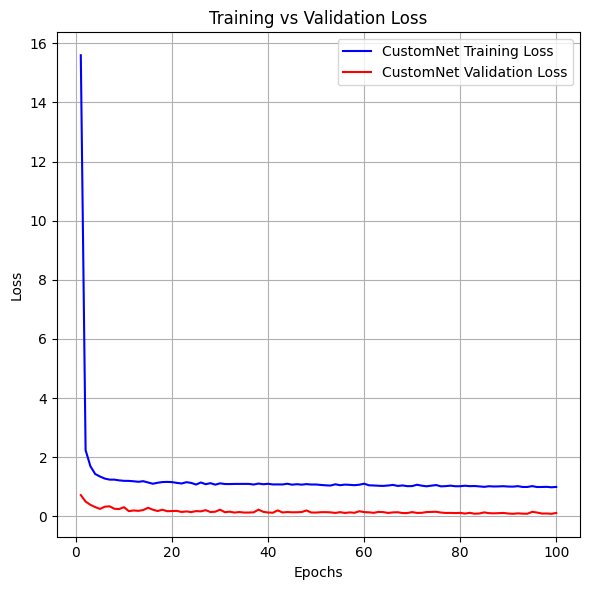

In [26]:
plot_loss_comparison(epochs, customnet_train_loss_array, customnet_val_loss_array, "CustomNet Training Loss", "CustomNet Validation Loss", "Training vs Validation Loss")

In [27]:
customnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = customnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_9416\1908420732.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


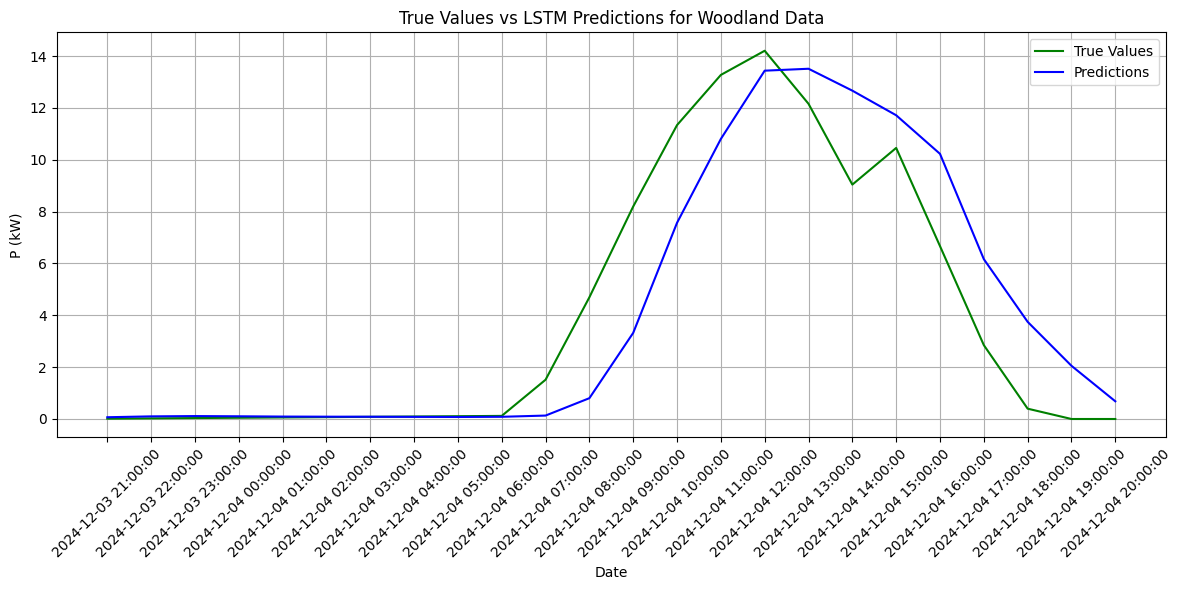

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs LSTM Predictions for Woodland Data')
plt.xlabel('Date')
plt.ylabel('P (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
mse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
r2 = r2_score(test["P (kW)"].values, predictions_test)
print(f"Mean Squared Error: {mse}")
print(f'R-squared value: {r2}')

Mean Squared Error: 2.2160315179683594
R-squared value: 0.8068279405944381
